# Importing Libraries

In [1]:
#importing all libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import hashlib
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change directory to 'DATASCI207_FinalProject'
os.chdir('/content/drive/My Drive/DATASCI207_FinalProject')

# Import Training, Validation, and Testing Datasets:

In [4]:
# Load the Pre-Processed Training Data:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

# Load the Pre-Processed Validation Data:
X_val = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')

# Load the Pre-Processed Testing Data:
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

# Creating a Baseline Model
For comparison to other, more complex model, we will build a baseline CNN model.

The selection of a baseline model is important, and in this case a complex choice. Because the aim of this model is to supplement doctors and healthcare professionals when making determinations on brain tumors, it is not enough to just simply build a majority classifier for the baseline model.

In this instance, we chose to build a simple Convolutional Neural Network (CNN) that has some ability to replicate the results of healthcare professionals. We will then attempt to build upon that model to improve results.

### Baseline Model Function
Creating a baseline model that is comprised of a simple 1-layer CNN:
- 1 Conv2D layer
- 1 MaxPooling layer
- 1 Dropout layer
- 1 Dense output layer

Using 12 filters, with a kernel size of (4,4) and a max pooling size of (2,2), we create the function:

In [5]:
def build_baseline_model(filters=12, kernel_size=(4,4), strides=(1,1), max_pool_size=(2,2), dropout=0.3):
  '''Function to create and compile a baseline CNN model. The model includes
     one Conv2D layer, one MaxPooling2D layer, and one Dense layer. Used for
     hyperparameter tuning.

     Input: hyperparameters, including: number of filters, kernel size, stride size
     max pooling size, dropout rate, and number of epochs.

     Output: compiled model with performance results.'''

  # Define early stopping case, checking validation accuracy. If the model
  # doesn't improve for 4 consecutive epochs, it stops training:
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    #monitor the validation accuracy
    verbose=1,
    #set to 4
    patience=4,
    #looks for the maximum value of validation accuracy
    mode='max',
    #After stopping, it goes back to the best model weights it had during training
    restore_best_weights=True
  )

  # Build a sequential model with one Conv2D layer and one MaxPooling layer:
  model = tf.keras.Sequential([
    # Use 12 filters and 4x4 grid of pixels:
    tf.keras.layers.Conv2D(filters=filters,
                           kernel_size=kernel_size,
                           strides=strides,
                           padding='same',
                           activation='relu',
                           input_shape=(224, 224, 3),
                           name='conv_1'),
    # Use MaxPooling layer:
    tf.keras.layers.MaxPooling2D(pool_size=max_pool_size),

    # Prevent overfitting by introducing a Dropout layer:
    tf.keras.layers.Dropout(dropout),

    # Flatten and add a Dense output layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])

  # Compile the model using the Adam optimizer:
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy', #labels are not one hot encoded so i used sparse categorical crossentropy
               metrics=['accuracy'])

  # Generate output summary:
  model.summary()

  return model, early_stopping

### Fit and Run the Model:
Run the model on 20 epochs and examine the results:

In [6]:
baseline_model, early_stopping = build_baseline_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 12)      588       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 12)      0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 4)                 602116    
                                                                 
Total params: 602704 (2.30 MB)
Trainable params: 602704 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

Epoch 1/20
259/259 [==============================] - 33s 126ms/step - loss: 0.7807 - accuracy: 0.7466 - val_loss: 0.6152 - val_accuracy: 0.7697
Epoch 2/20
259/259 [==============================] - 30s 118ms/step - loss: 0.2336 - accuracy: 0.9214 - val_loss: 0.6410 - val_accuracy: 0.7741
Epoch 3/20
259/259 [==============================] - 30s 116ms/step - loss: 0.1224 - accuracy: 0.9599 - val_loss: 0.8264 - val_accuracy: 0.7516
Epoch 4/20
259/259 [==============================] - 30s 118ms/step - loss: 0.0611 - accuracy: 0.9851 - val_loss: 0.6488 - val_accuracy: 0.8074
Epoch 5/20
259/259 [==============================] - 30s 118ms/step - loss: 0.0464 - accuracy: 0.9888 - val_loss: 1.0030 - val_accuracy: 0.7393
Epoch 6/20
259/259 [==============================] - 31s 119ms/step - loss: 0.0359 - accuracy: 0.9924 - val_loss: 0.4793 - val_accuracy: 0.8878
Epoch 7/20
259/259 [==============================] - 30s 117ms/step - loss: 0.0213 - accuracy: 0.9972 - val_loss: 0.9776 - val_ac

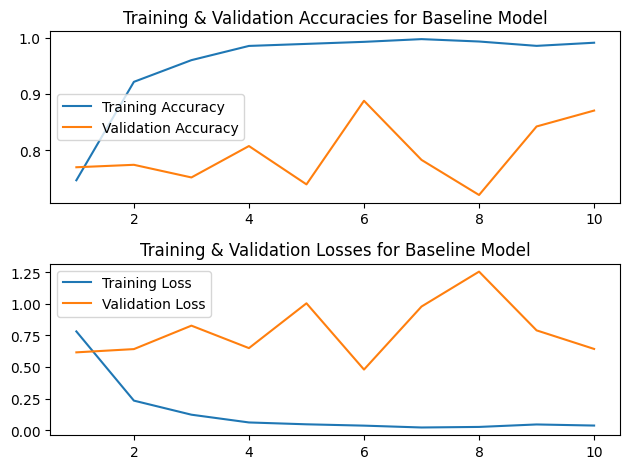

In [7]:
# Run for 20 epochs:
epochs=20

# Fit the model:
baseline_model_fit = baseline_model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping])

# Evaluate the model
_, train_accuracy = baseline_model.evaluate(X_train, Y_train)
print('Training Accuracy: {}'.format(train_accuracy))

_, val_accuracy = baseline_model.evaluate(X_val, Y_val)
print('Validation Accuracy: {}'.format(val_accuracy))

# Plot the results:
# Gather the accuracy and loss values from the model:
model_training_accuracies = baseline_model_fit.history['accuracy']
model_val_accuracies = baseline_model_fit.history['val_accuracy']

model_training_loss = baseline_model_fit.history['loss']
model_val_loss = baseline_model_fit.history['val_loss']

# Calculate the number of epochs for the x-axis:
num_epochs = np.arange(1, len(model_training_accuracies) + 1)

fig, ax = plt.subplots(nrows=2, ncols=1)

# Plot the model accuracies
ax[0].plot(num_epochs, model_training_accuracies, label='Training Accuracy')
ax[0].plot(num_epochs, model_val_accuracies, label='Validation Accuracy')

ax[0].set_title('Training & Validation Accuracies for Baseline Model')
ax[0].legend()

ax[1].plot(num_epochs, model_training_loss, label='Training Loss')
ax[1].plot(num_epochs, model_val_loss, label='Validation Loss')

ax[1].set_title('Training & Validation Losses for Baseline Model')
ax[1].legend()

plt.tight_layout()
plt.show()

### MaxPooling vs. AveragePooling:
To determine the effect of MaxPooling vs. AveragePooling on the baseline model, we created a function that would test both and simulate the baseline model over 10 epochs:

In [8]:
def average_vs_max_pooling(epochs):
  '''Function to test the difference between AveragePooling and MaxPooling layers
     in the baseline model.

     Input: number of epochs
     Output: plot of AveragePooling vs. MaxPooling for Validation Accuracy,
     Mean values of Validation Accuracy.'''

  # Create the first baseline model that uses AveragePooling:
  model_avg = tf.keras.Sequential([

  # Use the same parameters from the baseline model:
  tf.keras.layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 3), name='AveragePooling_Conv_1'),

  # Add AveragePooling layer:
  tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),

  # Prevent overfitting by adding Dropout:
  tf.keras.layers.Dropout(0.3),

  # Flatten and add Dense layer for output:
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4, activation='softmax')])

  # Create the first baseline model that uses MaxPooling:
  model_max = tf.keras.Sequential([

  # Use the same parameters from the baseline model:
  tf.keras.layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 3), name='MaxPooling_Conv_1'),

  # Add MaxPooling layer:
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Prevent overfitting by adding Dropout:
  tf.keras.layers.Dropout(0.3),

  # Flatten and add Dense layer for output:
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4, activation='softmax')])

  # Compile both models:
  model_avg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy', #labels are not one hot encoded so i used sparse categorical crossentropy
               metrics=['accuracy'])

  model_max.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy', #labels are not one hot encoded so i used sparse categorical crossentropy
               metrics=['accuracy'])

  # Fit both models:
  history_avg = model_avg.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

  history_max = model_max.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val))

  # Gather training accuracy and validation accuracy from both models:
  model_avg_training_accuracies = history_avg.history['accuracy']
  model_avg_val_accuracies = history_avg.history['val_accuracy']

  model_max_training_accuracies = history_max.history['accuracy']
  model_max_val_accuracies = history_max.history['val_accuracy']

  # Calculate num_epochs for x-axis:
  num_epochs = np.arange(1, epochs + 1)

  # Plot results:
  plt.plot(num_epochs, model_avg_val_accuracies, label = 'AveragePooling Validation Accuracy')
  plt.plot(num_epochs, model_max_val_accuracies, label = 'MaxPooling Validation Accuracy')
  plt.yticks(np.arange(0, 1, step=0.1))
  plt.title('Comparing AveragePooling and MaxPooling for our CNN')
  plt.legend()

  # Calculate mean values of validation accuracies:
  model_avg_mean = np.mean(model_avg_val_accuracies)
  model_max_mean = np.mean(model_max_val_accuracies)

  return f'AveragePooling mean = {model_avg_mean}. MaxPooling mean =  {model_max_mean}'

Epoch 1/10
259/259 [==============================] - 43s 163ms/step - loss: 0.8961 - accuracy: 0.7193 - val_loss: 0.5863 - val_accuracy: 0.7552
Epoch 2/10
259/259 [==============================] - 40s 155ms/step - loss: 0.3177 - accuracy: 0.8831 - val_loss: 0.6493 - val_accuracy: 0.7581
Epoch 3/10
259/259 [==============================] - 40s 156ms/step - loss: 0.2033 - accuracy: 0.9318 - val_loss: 0.5132 - val_accuracy: 0.8117
Epoch 4/10
259/259 [==============================] - 40s 155ms/step - loss: 0.1263 - accuracy: 0.9612 - val_loss: 0.5098 - val_accuracy: 0.8364
Epoch 5/10
259/259 [==============================] - 40s 155ms/step - loss: 0.0928 - accuracy: 0.9739 - val_loss: 0.6991 - val_accuracy: 0.7835
Epoch 6/10
259/259 [==============================] - 40s 154ms/step - loss: 0.0598 - accuracy: 0.9849 - val_loss: 0.7621 - val_accuracy: 0.7958
Epoch 7/10
259/259 [==============================] - 40s 155ms/step - loss: 0.0459 - accuracy: 0.9889 - val_loss: 0.6347 - val_ac

'AveragePooling mean = 0.8153511941432953. MaxPooling mean =  0.819333815574646'

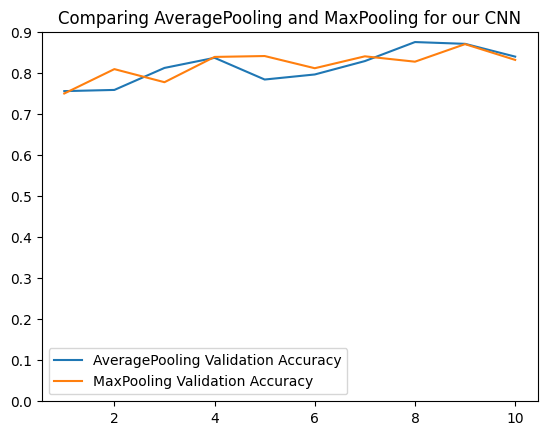

In [9]:
average_vs_max_pooling(epochs=10)

After running 10 epochs on both MaxPooling and AveragePooling, it is clear to see that neither have a significant effect on the baseline model. However, tumors present themselves as bright spots on MRI images. Because we want to highlight these cases, we will choose MaxPooling layers in our model moving forward.

In [12]:
# Save the baseline model:
baseline_model.save('/content/drive/My Drive/DATASCI207_FinalProject/baseline_model_fit.keras')

In [13]:
print(tf.__version__)

2.15.0
